# Ensemble Methods Advanced concepts

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

***Important*: install package `liac-arff` (use** `pip install liac-arff`**) in your environment<br>
Do not use and uninstall the package `arff` if it's already installed in your environment**

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from time import time
from sklearn import grid_search, cross_validation, metrics, ensemble, datasets
import arff
from addutils import css_notebook
import matplotlib.pyplot as plt
import sys
import os
import warnings
%matplotlib inline
css_notebook()


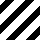
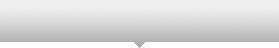
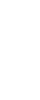
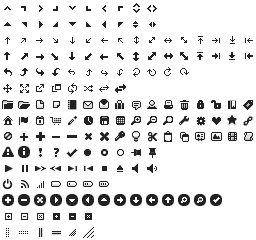
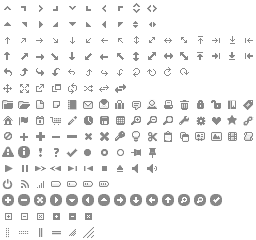
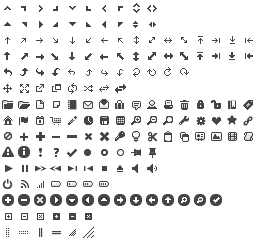
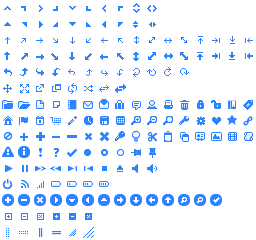
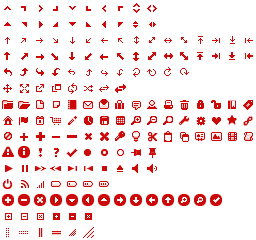
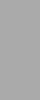
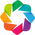
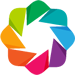
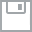
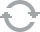
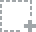
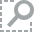
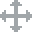
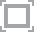
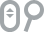

In [3]:
import bokeh.plotting as bk
bk.output_notebook()

## 1 Introduction

In this notebook we introduce some advanced techniques that can be used effectively with ensemble methods:

- OOB Score (Estimates)
- Feature Importance
- Partial Dependece Plot

## 2 Out of Bag Estimates

When using **ensemble methods** based upon **B**ootstrap **agg**regation or **Bagging**, i.e. using sampling with replacement, a part of the training set remains unused. For each classifier in the ensemble, a different part of the training set is left out. This left out portion can be used to **estimate the generalization error without having to rely on a separate Validation Set**. This estimate comes “for free” as no additional data is needed and can be used for model selection or for tuning hyperparameter.

This is currently implemented in the following classes:

  * `RandomForestClassifier` / `RandomForestRegressor`
  * `ExtraTreesClassifier` / `ExtraTreesRegressor`
  * `GradientBoostingClassifier` / `GradientBoostingRegressor` 

**Remarks**

In GradientBoosting OOB score is available only when `subsample` $< 1.0$. It can be used for a different purpose, that is finding the optimal number of boosting iterations, but it is a pessimistic estimator of the true test error. *Use it only for saving computataional time since, for example, cross-validation is more demanding*.

### 2.1 Phishing Websites Data Set
For testing OOB Score properties of ensemble method we used a publicly available dataset. The dataset is the Phishing Websites Data Set and can be downloaded from [here](https://archive.ics.uci.edu/ml/datasets/Phishing+Websites). This dataset is anonymized by replacing the actual strings with describing values.

The dataset is available in Weka format, so we have to use the *Weka arff file type reader for python* to read it.

In [4]:
#load the dataset
data = arff.load(open('example_data/Training Dataset.arff', 'rb'))
print "Keys: "
for k in data.keys():
    print "- " + k

Keys: 
- attributes
- relation
- description
- data


In "attributes" are stored the column names while actual data is stored in "data". The dataset is further divided into training and test set to compare OOB score with CV and held out set.

In [5]:
#use the dataset to build a dataframe
cols = [at[0] for at in data['attributes']]
df = pd.DataFrame(data['data'], dtype=int, columns=cols)
print "Shape of the data: {0}".format(df.shape)
target = df.iloc[:,-1]
train = df.iloc[:,:-1]
#split the dataframe in train / test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train, 
                                                                     target, 
                                                                     test_size=0.2)
print "Training set / Test set number of samples: {0}, {1}".format(X_train.shape[0], 
                                                                   X_test.shape[0])
print "Number of features: {0}".format(X_train.shape[1])

Shape of the data: (11055, 31)
Training set / Test set number of samples: 8844, 2211
Number of features: 30


In [6]:
pd.options.display.max_columns=6
df.head(3)

,having_IP_Address,URL_Length,Shortining_Service,...,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,...,1,-1,-1
1,1,1,1,...,1,1,-1
2,1,0,1,...,0,-1,-1


### 2.2 OOB estimate Random Forest
Test OOB score against cross-validation and test set. In order to perform OOB score calculation the option oob_score must be set to True.

In [7]:
t0 = time()
rfc = ensemble.RandomForestClassifier(n_estimators=1000, 
                                      oob_score=True, 
                                      random_state=42,
                                      n_jobs=-1)
rfc.fit(X_train, y_train)
print 'RF fit done in %0.3f[s]' %(time() - t0)
t0 = time()
cv_score = cross_validation.cross_val_score(rfc, train, target, cv=10, n_jobs=-1)
print 'CV score calculated in %0.3f[s]' %(time() - t0)

RF fit done in 5.195[s]
CV score calculated in 51.421[s]


As can be seen in this example, using CV to measure the score takes time and it is similar to that obtained from OOB samples, that comes with the algorithm at no additional computational costs.

In [8]:
print 'Score comparison:'
print 'F1 score (on the test set):'.ljust(40), '%f' % metrics.f1_score(rfc.predict(X_test),\
                                                                       y_test)
print 'OOB score:'.ljust(40), '%f' % rfc.oob_score_
print 'CV score (on the entire training set):'.ljust(40), '%f' % cv_score.mean()

Score comparison:
F1 score (on the test set):              0.974233
OOB score:                               0.971732
CV score (on the entire training set):   0.973038


### 2.3 OOB estimate Gradient Boosting

**Please be patient: the following cell will require up to 10 minutes to be computed**

In [9]:
# Fit classifier with out-of-bag estimates
params = {'n_estimators': 11000, 
          'max_depth': 3, 
          'subsample': 0.5,
          'learning_rate': 0.1, 
          'min_samples_leaf': 1, 
          'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

t0 = time()
clf.fit(X_train, y_train)
print 'GBRT fit done in %0.3f[s]' %(time() - t0)
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1

def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score


def cv_estimate(n_folds=3):
    cv = cross_validation.KFold(n=X_train.shape[0], n_folds=n_folds, random_state=42)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv:
        cv_clf.fit(X_train.iloc[train], y_train.iloc[train])
        val_scores += heldout_score(cv_clf, X_train.iloc[test], y_train.iloc[test])
    val_scores /= n_folds
    return val_scores


# Estimate best n_estimator using cross-validation
t0 = time()
cv_score = cv_estimate(3)
print 'CV score estimate done in %0.3f[s]' %(time() - t0)

# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

GBRT fit done in 245.153[s]
Accuracy: 0.9692
CV score estimate done in 507.456[s]


As stated in the introduction OOB estimate for Gradient Boosting can be used for computing the optimal number of boosting itarations. It has the advantage of being computed on the fly as a byproduct of the algorithm, but it has the disadvantage of being a pessimistic estimate of the actual loss, especially for high number of trees. In the following picture the OOB loss estimate is plotted against test and CV score. The curves represent the cumulative sum of negative improvement as a function of the number of boosting iterations. The vertical line represent the point were the curve is lower.

In [61]:
from bokeh.models import LinearAxis, Range1d

fig = bk.figure(plot_width=700, plot_height=500)
fig.line(x, cumsum, color="blue", legend="OOB loss")
fig.ray(x=oob_best_iter, y=0, length=0, angle=(np.pi / 2), line_width=1, color="blue")
fig.ray(x=oob_best_iter, y=0, length=0, angle=-(np.pi / 2), line_width=1, color="blue")
fig.text(x=oob_best_iter+100, y=-85, text=["OOB best"], text_font_size='8pt')

fig.line(x, test_score, color="red", legend="Test loss")
fig.ray(x=test_best_iter, y=0, length=0, angle=(np.pi / 2), line_width=1, color="red")
fig.ray(x=test_best_iter, y=0, length=0, angle=-(np.pi / 2), line_width=1, color="red")
fig.text(x=test_best_iter-900, y=-80, text=["Text best"], text_font_size='8pt')

fig.line(x, cv_score, color="green", legend="CV loss")
fig.ray(x=cv_best_iter, y=0, length=0, angle=(np.pi / 2), line_width=1, color="green")
fig.ray(x=cv_best_iter, y=0, length=0, angle=-(np.pi / 2), line_width=1, color="green")
fig.text(x=cv_best_iter-900, y=-85, text=["CV best"], text_font_size='8pt')

fig.xaxis.axis_label = "number of iterations"
fig.xaxis.axis_label_text_font_size = '10pt'
fig.yaxis.axis_label = "normalized loss"
fig.yaxis.axis_label_text_font_size = '10pt'

bk.show(fig)

As we can see from the picture, the OOB score start increasing for a low number of iterations, while CV and Test loss continue decreasing. Use this feature only when performing Cross Validation overhead is unacceptable. 

## 3 Ensemble Methods comparison

We can use this example to further compare Random Forest and Gradient Boosting Regression Trees. 

Playing with the parameters of RF and GBRT we can compare their performance regarding both accuracy and speed. As can be seen in order to have the same amount of accuracy, GBRT needs a considerable number of iterations with respect to RF (at least with this particular dataset). With a lower number of trees (as low as 100 suffice) RF achieve the same accuracy (or better in some cases) than GBRT with lots (up to 12000) iterations. Moreover the number of iterations causes GBRT algorithm to run in quite amount of time. Compare the time employed by RF to fit the data with that of GBRT; with the same number of trees/iteration GBRT runs up to 5 time slower than RF (in this example). RF can run faster because they can be paralallelized while GBRT cannot, at least in the implementation of scikit-learn. 

Another implementation of GBRT, namely **XGBoost** (e**X**treme **G**radient **Boost**ing, **XGB**) is a library for parallelized and distributed gradient boosting. It is available on github ([here](https://github.com/dmlc/xgboost)) and can run both on single node multiprocessors or on distributed clusters such as hadoop or yarn. It has wrappers for several languages, including python.

**REMARK** Please make sure XGBoost is installed on your machine, note that this version was installed from source (at the moment this notebook was made, `pip` version had few problems).

In [11]:
import xgboost as xgb

params = {'n_estimators': 11000, 
          'max_depth': 3, 
          'subsample': 0.5,
          'learning_rate': 0.1}

xgb_model = xgb.XGBClassifier(**params)

t0 = time()
xgb_model.fit(X_train, y_train)
print 'XGBoost fit done in %0.3f[s]' %(time() - t0)
xgb_acc = xgb_model.score(X_test, y_test)
print("Accuracy: {:.4f}".format(xgb_acc))

XGBoost fit done in 154.726[s]
Accuracy: 0.9692


As can be seen in the last code block, XGBoost achieve the same amount of precision of GBRT but in less than a half of the time. Speed is still lower than RF but remember that these comparison are made with a particular dataset and performance is dataset specific. In situation (and dataset) where GBRT performs better than RF it is possible to switch to XGB to lower computational time.

As mentioned above, there are indeed certain datasets where Gradient Boosting methods perform better than Random Forest. One of the advantages of GBRT over RF is its ability to inherently treat additive functions. We can compare the two methods usind a synthetic dataset built with an additive function by using `make_hastie_10_2` as in the previous notebook. Of course this is a toy example used only to show the properties of the algorithm. 

In [12]:
X_hastie, y_hastie = datasets.make_hastie_10_2(n_samples=10000, random_state=42)
labels, y_hastie = np.unique(y_hastie, return_inverse=True)
X_hastie_train, X_hastie_test = X_hastie[:2000], X_hastie[2000:]
y_hastie_train, y_hastie_test = y_hastie[:2000], y_hastie[2000:]

In the next block we train a GBRT classifier with `max_leaf_nodes = 4` and $1000$ number of iterations. This setting has the same number of leaves as using a tree of depth $2$, which is the best depth for this dataset as we found out in the previous notebook. Changing the parameter type in this case slightly increases performance, probably because the particular problem is best represented by an unbalanced tree.

In [13]:
gbrt = ensemble.GradientBoostingClassifier(n_estimators=1000, max_leaf_nodes=4)
gbrt.fit(X_hastie_train, y_hastie_train)
y_gbrt = gbrt.predict(X_hastie_test)

print ("F1 score: {0}".format(metrics.f1_score(y_gbrt, y_hastie_test)))

F1 score: 0.927492063492


Next we train a Random Forest choosing parameters with a grid search to reach the best possible result. 

In [14]:
rfc = ensemble.RandomForestClassifier(random_state=42, n_jobs=-1)
hastie_params = {'n_estimators':[100, 500],
                 'max_features':['auto', 8],
                 'max_depth':[None, 5]}

grid_hastie = grid_search.GridSearchCV(rfc, hastie_params, cv=10, n_jobs=-1)
grid_hastie.fit(X_hastie_train, y_hastie_train)
rfc_best = grid_hastie.best_estimator_

print "Best parameters"
for k, value in grid_hastie.best_params_.iteritems():
    print k + ":\t" + str(value)

y_rfc = rfc_best.predict(X_hastie_test)

print ("F1 score: {0}".format(metrics.f1_score(y_rfc, y_hastie_test)))

Best parameters
max_features:	auto
n_estimators:	500
max_depth:	None
F1 score: 0.87555079195


Comparing score of the two algorithms we can see that GBRT performs better than RF (even if we tuned it a little bit more). This behavior can be explained by the particular dataset used. As noted in the introduction the dataset is generated by an additive function and RF are known to be "non-additive" ensemble methods. Note that changing the depth of the trees of the Random Forest to a lower parameter (shallow trees) does not improve performance.

This behavior could be explained by noting that, in Random Forest, when features exhibit a pure interaction, there is no evident main effect and the first split is essentially a random split (each splitting point does not produce a clear decrese in node impurity). For such reason the algorithm may get lost in the way of building each tree and never really find a suitable function representation.

**TODO** Change the cell below in order to show the picture embedded in the notebook (Seba is updating the module). At the moment the cell is not executed.

sys.path.append(os.getcwd()+'/ensemble-explore')

import app
wac = app.WebAppController()
agg = app.core.AggregateTree(rfc_best)
feat_info = app.collect_features_info(rfc_best, range(10))
wac.args.aggregate_tree = agg
wac.args.features_info = feat_info
wac.start()

wac.stop()

## 4 Feature importance evaluation

Ensemble methods can provide a measure of importance for each feature in the dataset. This measure can be used to asses how much the feature is important in predicting the response and thus to select the most important features and reduce dimensionality. 

Random Forests have two ways to assign a measure of importance, namely: mean decrease in node impurity and mean decrease in accuracy.

- _mean decrease in node impurity:_ In scikit-learn the feature importance is provided by looking at each split in each tree. The importance of the splitting variable is proportional to the improvement to the gini index given by that split and it is accumulated (for each variable) over all the trees in the forest.
- _mean decrease in accuracy:_ This method, proposed in the original paper, uses the OOB samples to construct the measure. In practice when a given tree is constructed the OOB samples are passed down the tree and the prediction accuracy is recorded. Then a variable is chosen and its values are permuted (in the OOB samples) and the accuracy is computed again. A decrease in accuracy obtained by this permutation is averaged over all trees for each variable and it provides the importance of that variable (the higher the decreas the higher the importance). This method has better statistical properties with respect to the other and it is used in other implementation such as the package randomForest in the R language. We propose a module that calculate this score for scikit-learn.

In this example we use two different `ensemble` algorithms on the *Boston Housing Dataset*: first we use a `RandomForestRegressor` algotithm, then we run a `GradientBoostingRegressor` on the same dataset, in order to understand how variable importance differs in the two algorithms.

Let's start by reading the *Boston Housing Dataset* and storing it properly in a `pandas DataFrame`:

In [15]:
from sklearn.datasets import load_boston

warnings.filterwarnings("ignore", category=DeprecationWarning)
data = load_boston()
boston = pd.DataFrame(data.data, columns=data.feature_names)#[:-1])
# Assign more descriptive names, see data.DESCR for more info
boston = boston.rename(columns={u'CRIM':'Per Capita Crime Rate',
                                u'ZN':'Land_zn / lots_over_25k_sqft',
                                u'INDUS':'Prop non-retail business acres',
                                u'CHAS':'Bounds Charles River',
                                u'NOX':'NOX Concentration',
                                u'RM':'Avg Rooms per Dwelling',
                                u'AGE':'Prop units built prior 1940',
                                u'DIS':'Distance from Biz Centers',
                                u'RAD':'Accessibility to Highways',
                                u'TAX':'Property TAX rate per $10k',
                                u'PTRATIO':'Pupil-Teacher Ratio',
                                u'B':'Prop of Blacks',
                                u'LSTAT':'% Lower pop Status'})
print boston.shape

(506, 13)


Split the data in **Training and Validation Set**:

In [16]:
idx_train, idx_valid = cross_validation.train_test_split(boston.index, test_size=0.20)
boston_train, boston_valid = boston.ix[idx_train], boston.ix[idx_valid]
bostony_train, bostony_valid = data.target[idx_train], data.target[idx_valid]

### 4.1 Random Forest Importance

In this example we use a Random Forest Regressor and we choose the best estimator based on Cross Validation score.

In [17]:
param_grid = [{'n_estimators': [25, 50, 100, 200],
               'max_depth': [16, 32],
               'min_samples_split' : [2, 4],
               'min_samples_leaf' : [1],
               'bootstrap' : [True]}]
t0 = time()
rfr = grid_search.GridSearchCV(ensemble.RandomForestRegressor(),
                               param_grid, cv=5, verbose=0)
rfr.fit(boston_train, bostony_train)
print 'Done in %0.3f[s]' %(time() - t0)

Done in 33.870[s]


Next we highlight the best estimator parameters and its outcome.

In [18]:
best_estimator = rfr.best_estimator_
for key, value in rfr.best_params_.items():
    print key.ljust(20), ':', value

bostony_predic = best_estimator.predict(boston_valid)

fig = bk.figure(plot_width=500, plot_height=350)
fig.title_text_font_size = '11pt'
fig.circle(bostony_valid, bostony_predic, size=5)

fig.title = "True vs Predicted Price"
fig.xaxis.axis_label = 'True price ($1000s)'
fig.yaxis.axis_label = 'Predicted price ($1000s)'
fig.axis.axis_label_text_font_size = '9pt'
fig.grid.grid_line_color = None
fig.axis.minor_tick_out = 0
fig.axis.major_tick_out = 0
fig.axis.major_tick_in = 3

bk.show(fig)

min_samples_split    : 4
n_estimators         : 25
bootstrap            : True
max_depth            : 16
min_samples_leaf     : 1


We display the features ordered from the most important to the least important. In the next plot we can see the same information but with the bar that corresponds to the relative importance of each feature compared to the most important one. The importance in this case is calculated with the "gini" (__mean decrease impurity__) of scikit-learn.

In [19]:
feature_importance_raw = best_estimator.feature_importances_
feature_importance = 100.0*(feature_importance_raw/feature_importance_raw.max())
feature_importance_sorted_idx = np.argsort(feature_importance)[::-1]
#print feature_importance_sorted_idx
# Print the feature ranking
print("Feature ranking:")

for f in range(len(feature_importance_sorted_idx)):
    print("%d. feature %s (%f)" % (f + 1, 
                                   boston.columns[feature_importance_sorted_idx[f]], 
                                   feature_importance_raw[feature_importance_sorted_idx[f]]))

Feature ranking:
1. feature % Lower pop Status (0.418917)
2. feature Avg Rooms per Dwelling (0.383299)
3. feature Distance from Biz Centers (0.074263)
4. feature Per Capita Crime Rate (0.031788)
5. feature NOX Concentration (0.018999)
6. feature Property TAX rate per $10k (0.018302)
7. feature Pupil-Teacher Ratio (0.017484)
8. feature Prop units built prior 1940 (0.014420)
9. feature Prop of Blacks (0.010468)
10. feature Prop non-retail business acres (0.005571)
11. feature Accessibility to Highways (0.004599)
12. feature Bounds Charles River (0.001439)
13. feature Land_zn / lots_over_25k_sqft (0.000451)


In [20]:
sorted_idx = feature_importance_sorted_idx[::-1]
cols = list(boston.columns[sorted_idx])
fig = bk.figure(plot_width=750, plot_height=400, 
                title='Variable Importance',
                y_range=cols, x_range=(0, 100))
fig.title_text_font_size = '10.5pt'
fig.segment(0, cols,  
            feature_importance[sorted_idx], cols,
            line_width=20)
fig.xaxis.axis_label = 'Relative Importance'
fig.xaxis.axis_label_text_font_size = '9pt'

bk.show(fig)

The following two cells demonstrate the use of the other methods for calculating feature importance (__mean decrease in accuracy__). We use a module called `importance` provided with `addutils` package.

In [21]:
#sys.path.append(os.getcwd() + "/utilities")
#import importance
from addutils import importance

In [22]:
mda_feature_importance_raw = importance.importance(best_estimator, 
                                                   boston_train.values, 
                                                   bostony_train, 
                                                   importance.reg_score)
mda_feature_importance_raw = mda_feature_importance_raw.mean(axis=0)
mda_feature_importance = 100.0*(mda_feature_importance_raw/mda_feature_importance_raw.max())
mda_feature_importance_sorted_idx = np.argsort(mda_feature_importance)[::-1]
#print feature_importance_sorted_idx
# Print the feature ranking
print("Feature ranking:")

for f in range(len(mda_feature_importance_sorted_idx)):
    print("%d. feature %s (%f)" % (f + 1, 
                                   boston.columns[mda_feature_importance_sorted_idx[f]], 
                                   mda_feature_importance_raw[mda_feature_importance_sorted_idx[f]]))

Feature ranking:
1. feature % Lower pop Status (69.492921)
2. feature Avg Rooms per Dwelling (50.325506)
3. feature Distance from Biz Centers (10.378505)
4. feature Per Capita Crime Rate (6.708866)
5. feature NOX Concentration (4.830166)
6. feature Property TAX rate per $10k (4.497247)
7. feature Pupil-Teacher Ratio (4.474248)
8. feature Prop units built prior 1940 (2.962124)
9. feature Accessibility to Highways (1.839899)
10. feature Prop of Blacks (1.077626)
11. feature Prop non-retail business acres (0.937228)
12. feature Bounds Charles River (0.144314)
13. feature Land_zn / lots_over_25k_sqft (0.088717)


In [23]:
mda_sorted_idx = mda_feature_importance_sorted_idx[::-1]
cols = list(boston.columns[mda_sorted_idx])
fig = bk.figure(plot_width=750, plot_height=400, 
                title='Variable Importance',
                y_range=cols, x_range=(0, 100))
fig.title_text_font_size = '10.5pt'
fig.segment(0, cols,  
            mda_feature_importance[mda_sorted_idx], cols,
            line_width=20)
fig.xaxis.axis_label = 'Relative Importance'
fig.xaxis.axis_label_text_font_size = '9pt'

bk.show(fig)

In the literature the two approaches differs mainly because _gini impurity_ is biased in favor of continuous variables and variables with many categories (for variables of different types), while _mean decrease accuracy_ is unbiased (only when subsampling is not used).

As long as this dataset is concerned, the two approaches have similar results. This can be explained by the fact that all variables are of the same type and thus either approach can be used succesfully. 

### 4.2 Gradient Boosting Importance

In this example we use a Gradient Boosting Regressor Tree and we choose the best estimator based on Cross Validation score.

In [24]:
gbr = ensemble.GradientBoostingRegressor()
params = {'n_estimators':[100, 200, 500],
          'max_depth':[4, 6],
          'learning_rate':[0.1, 0.01],
          'subsample':[0.5]}
t0 = time()
grid = grid_search.GridSearchCV(gbr, params, n_jobs=-1)
grid.fit(boston_train, bostony_train)

print 'Done in %0.3f[s]' %(time() - t0)

Done in 7.543[s]


In [25]:
gbr_best = grid.best_estimator_
for key, value in grid.best_params_.items():
    print key.ljust(20), ':', value

bostony_predic = gbr_best.predict(boston_valid)

n_estimators         : 500
subsample            : 0.5
learning_rate        : 0.1
max_depth            : 4


In [26]:
gbr_feature_importance_raw = gbr_best.feature_importances_
gbr_feature_importance = 100.0*(gbr_feature_importance_raw/gbr_feature_importance_raw.max())
gbr_feature_importance_sorted_idx = np.argsort(gbr_feature_importance)[::-1]

print("Feature ranking:")

for f in range(len(feature_importance_sorted_idx)):
    print("%d. feature %s (%f)" % (f + 1, 
                                   boston.columns[gbr_feature_importance_sorted_idx[f]], 
                                   gbr_feature_importance_raw[gbr_feature_importance_sorted_idx[f]]))

Feature ranking:
1. feature Avg Rooms per Dwelling (0.162317)
2. feature % Lower pop Status (0.149274)
3. feature Per Capita Crime Rate (0.123829)
4. feature Distance from Biz Centers (0.122157)
5. feature Prop of Blacks (0.121896)
6. feature Prop units built prior 1940 (0.114573)
7. feature NOX Concentration (0.055908)
8. feature Pupil-Teacher Ratio (0.042311)
9. feature Property TAX rate per $10k (0.040816)
10. feature Prop non-retail business acres (0.030375)
11. feature Land_zn / lots_over_25k_sqft (0.016134)
12. feature Accessibility to Highways (0.015275)
13. feature Bounds Charles River (0.005136)


In [27]:
gbr_sorted_idx = gbr_feature_importance_sorted_idx[::-1]
cols = list(boston.columns[gbr_sorted_idx])
fig = bk.figure(plot_width=700, plot_height=400,
                title='Variable Importance',
                y_range=cols, x_range=(0, 100))
fig.title_text_font_size = '10.5pt'
fig.segment(0, cols,  
            gbr_feature_importance[gbr_sorted_idx], cols,
            line_width=20)
fig.xaxis.axis_label = 'Relative Importance'
fig.xaxis.axis_label_text_font_size = '9pt'

bk.show(fig)

Due to shrinkage, GBRT variable importance has the advantage, over Random Forest, to be less susceptible to the masking effect that high correlated variables have; that is it should be easier to spot all important variables even if they are correlated.

## 5 Partial Dependence Plots
**Partial dependence plots (PDP)** show the dependence between the target response and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the ‘target’ features.

Due to the limits of human perception the size of the target feature set must be small (usually, one or two) thus the target features are usually chosen among the most important features. In the next section we evaluate the importance of features using Random Forest and then we use only the most important ones in the plot.

### 5.1 California Housing Dataset

California Housing is obtained from the StatLib repository. Here is the included description:

*S&P Letters Data
We collected information on the variables using all the block groups in California from the 1990 Cens us. In this sample a block group on average includes 1425.5 individuals living in a geographically co mpact area. Naturally, the geographical area included varies inversely with the population density. We computed distances among the centroids of each block group as measured in latitude and longitude. We excluded all the block groups reporting zero entries for the independent and dependent variables. The final data contained 20,640 observations on 9 variables. The dependent variable is ln(median house value).*



In [28]:
from sklearn.datasets.california_housing import fetch_california_housing

# fetch California housing dataset
cal_housing = fetch_california_housing()

Cal_train, Cal_test, Caly_train, Caly_test = cross_validation.train_test_split(cal_housing.data, 
                                                                               cal_housing.target,
                                                                               test_size=0.2,
                                                                               random_state=1)
names = cal_housing.feature_names

In the following example, we use scikit-learn's RandomForestRegressors to asses variable importance. 

In [29]:
forest = ensemble.RandomForestRegressor(n_estimators=500, max_features=0.3)
forest.fit(Cal_train, Caly_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.3, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [30]:
importances_raw = forest.feature_importances_
importances = 100.0 * (importances_raw / importances_raw.max())
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [31]:
rev_indices = indices[::-1]
cols = [names[r] for r in rev_indices]
fig = bk.figure(plot_width=700, plot_height=300,
                title='Variable Importance',
                y_range=cols, x_range=(0, 100))
fig.title_text_font_size = '10.5pt'
fig.segment(0, 
            cols,  
            importances[rev_indices], 
            cols,
            line_width=20)
fig.xaxis.axis_label = 'Relative Importance'
fig.xaxis.axis_label_text_font_size = '9pt'

bk.show(fig)

Here the length of the bar represents the percentage value of feature importance relative to the most important feature. The plot suggests that one features, namely MedInc captures most of the variability in the data.

In the following plot we can see variable importance calculated with the method "mean decrease accuracy".

In [32]:
mda_importance = importance.importance(forest, Cal_train, Caly_train, importance.reg_score)
mda_importances_raw = mda_importance.mean(axis=0)
mda_importances = 100.0 * (mda_importances_raw / mda_importances_raw.max())
mda_indices = np.argsort(mda_importances)[::-1]

In [33]:
rev_mda_indices = mda_indices[::-1]
cols = [names[r] for r in rev_mda_indices]
fig = bk.figure(plot_width=700, plot_height=300,
                title='Variable Importance',
                y_range=cols, x_range=(0, 100))
fig.title_text_font_size = '10.5pt'
fig.segment(0, 
            cols,  
            mda_importances[rev_mda_indices], 
            cols,
            line_width=20)
fig.xaxis.axis_label = 'Relative Importance'
fig.xaxis.axis_label_text_font_size = '9pt'

bk.show(fig)

Both measures says that Median Income in the neighborhood is the most relevant feature (not surprisingly). Longitude, Latitude, and Average Occupancy are still influencial and we choose to include HouseAge and AveRooms because they can give more insights into the driving factor of house price. With only latitude and longitude features, the model learns the price of the house given its position regardless of other factor that may affect the price.

### 5.2 Partial Dependence Plots

Based on the observation above we plot only the first most important features. In the picture below the plot shows six single-variable partial dependence. The plots are not smooth because we are using a tree based method. The marks at the bottom of each plots delineates the deciles of the data distribution of the variable. Note that the density is lower near the edges.

In [34]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [35]:
clf = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                learning_rate=0.1, loss='huber', random_state=1)
clf.fit(Cal_train, Caly_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1,
             loss='huber', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=1, subsample=1.0, verbose=0, warm_start=False)

In [36]:
warnings.filterwarnings('ignore', category=UnicodeWarning)

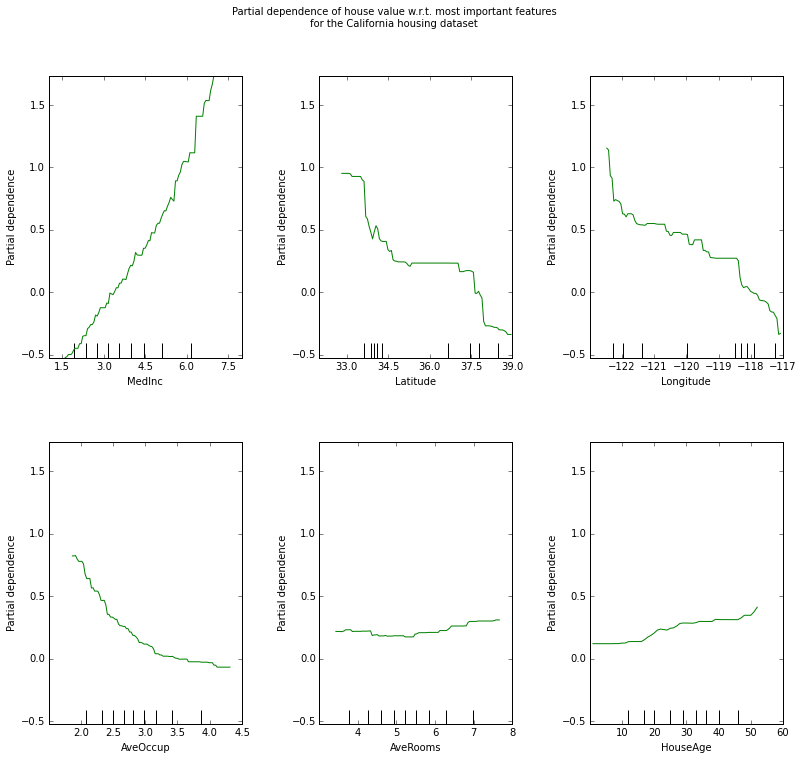

In [37]:
# sklearn uses Matplotlib for its plotting functions (like `plot_partial_dependence')
%matplotlib inline
import matplotlib.pyplot as plt 

plt_number = 6
features = list(indices[:plt_number])
#features += zip(features[0::2], features[1::2])
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

fig, axs = plot_partial_dependence(clf, Cal_train, features, feature_names=names,
                                   n_jobs=-1, grid_resolution=100, ax=ax)
fig.suptitle('Partial dependence of house value w.r.t. most important features\n'
             'for the California housing dataset')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

**TODO:** Correggere questa cella dopo avere sistemato il grafico usando le features più importanti (da analisi precedente). AGGIUNGERE: 3 grafici 3d come da esempio sklearn. 

**REPLY** Ho aggiunto solo un grafico 3D per far vedere la correlazione tra due variabili come descritto nel testo di Tibshirani e Hastie.

The figure above shows four one-way and two two-way partial dependence plots for the California housing dataset: the target variables for the one-way PDP are: median income (MedInc), avg. occupants per household (AvgOccup), latitude (Latitude), longitude (Longitude).

The partial dependence of median house price shows a (monotonically increasing) linear relationship with the median income (top left). House value is generally monotonically decreasing with increasing average occupancy (top middle). 

Median house value has a weak partial dependence with HouseAge that is inconsistent with its ranking (and common sense). This behavior may suggest an interaction effect with other variables. The following plot shows a two-variable dependency plot of house value on joint values of house age and average occupancy

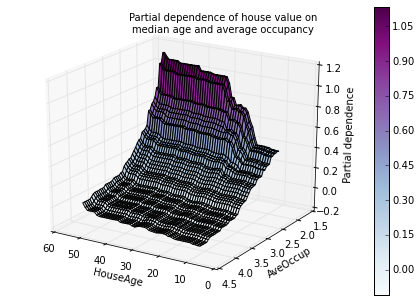

In [63]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

#target_feature = list(indices[:2])
target_feature = (1,5)
pdp, (x_axis, y_axis) = partial_dependence(clf, target_feature,
                                           X=Cal_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on \n'
            'median age and average occupancy')
plt.subplots_adjust(top=0.9)

plt.show()

The two-way partial dependence plot shows the dependence of median house price on joint values of house age and avg. occupants per household. We can clearly see an interaction between the two features: for an avg. occupancy greater than two, the house price is nearly independent of the house age, whereas for values less than two there is a strong dependence on age.

## 6 Ensemble Methods, practical considerations

**TODO** Explain when each Ensemble gets in trouble and how to overcome this. Try to sketch a decision process.

Ensemble methods are non-parametric models with few hyperparameters to set. They can model complex iteraction between variable and learn complex functions. In the next section we will try to sketch a possible use cases for Ensemble Methods.

- Is there an a-priori knowledge of the model underlying the particular dataset?
    1. NO. use a non-parametric model such as RF or GBRT
    2. YES. use a parametric model (such as linear regression). It is still usefull though to compare results of a parametric model with results of a RF or GBRT especially if the former does not achieve good performance. 

- Do we know that the model is sparse?
    1. YES. Use a sparse model such as LASSO. Random Forest performance in this case are worse. Lasso however doesn't automatically capture high order correlation between variables and non-linear relationship. All the interaction and nonlinearties must be explicitly added by the user. Doing this could be 
    2. NO. If feature importance of a Random Forest displays high variability it might be the that few features are relevant and the algorithm cannot capture that relationship. In presence of such behavior it could be worth trying with LASSO or other sparse methods.
    
- Does the model come from an additive function?
    1. YES. Try using GBRT instead of RF. If performance are an issue, use XGB.
    2. NO. Try using a RF.

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.